# **ECG200**

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import Counter
import scipy.stats as stats # for the breakpoints in SAX
from scipy.stats import norm
from dtw import dtw
from matplotlib import cm

##Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns

## TSLEARN
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset

## Custom
from Symbol import SYMBOLS
from SFA import *
from ASTRIDE import *
from SAX_transf import *
from distances import MINDIST
import utils
import warnings 
from utils import plot_3D
from utils import plot_recons

## Aeon
warnings.filterwarnings('ignore')
import os
import aeon
from aeon.datasets import load_classification

# Dataset Information

**Data Source:** [Link](https://timeseriesclassification.com/description.php?Dataset=ECG200)

**Donated By:** R. Olszewski  

**Description:**  
This dataset was formatted by R. Olszewski as part of his thesis *"Generalized feature extraction for structural pattern recognition in time-series data"* at Carnegie Mellon University, 2001. Each series traces the electrical activity recorded during one heartbeat. The two classes are:
- **Normal heartbeat**  
- **Myocardial Infarction**  

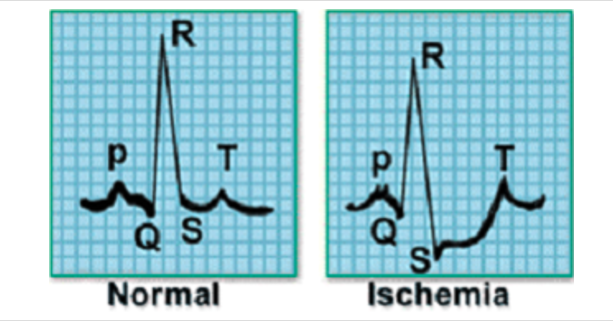

Ce qui est intéressant avec ce dataset est que la différence d'une classe à l'autre se voit dans les pics. 

# Dataset Summary

| **Train Size** | **Test Size** | **Length** | **Number of Classes** | **Number of Dimensions** | **Type** |
|-----------------|--------------|------------|------------------------|--------------------------|----------|
| 100             | 100          | 96         | 2                      | 1                        | ECG      |


In [8]:
train_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TRAIN.ts")
test_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TEST.ts")

X_train = pd.read_csv(train_path, 
                      sep=",", 
                      header=None
                      )

X_train.columns = list(X_train.columns[:-1]) + ['label']
x_train, y_train = X_train.iloc[:, :-1], X_train["label"]

y_train = y_train.replace(-1, 0)

X_test = pd.read_csv(test_path, 
                      sep=",", 
                      header=None
                      )

X_test.columns = list(X_test.columns[:-1]) + ['label']
x_test, y_test = X_test.iloc[:, :-1], X_test["label"]

y_test = y_test.replace(-1, 0)


### Visualisation des données

Dans un premier temps, on s'approprie le dataset avec quelques statistiques descriptives ainsi que les séries temporelles archetypiques des 2 classes. La classe $1$ représente donc les enregistrements de battements de coeur sains ou normaux tandis que le label $-1$ représente un Ischemia Heartbeat. 

In [3]:
utils.describe_ecg_dataset(X_train, y_train, X_test, y_test)

Nombre d'exemples dans l'ensemble d'entraînement : 100
Nombre d'exemples dans l'ensemble de test : 100
Longueur des séries temporelles : 97


Répartition des classes (Ensemble d'entraînement) :
label
0    31
1    69
Name: count, dtype: int64

Répartition des classes (Ensemble de test) :
label
0    36
1    64
Name: count, dtype: int64




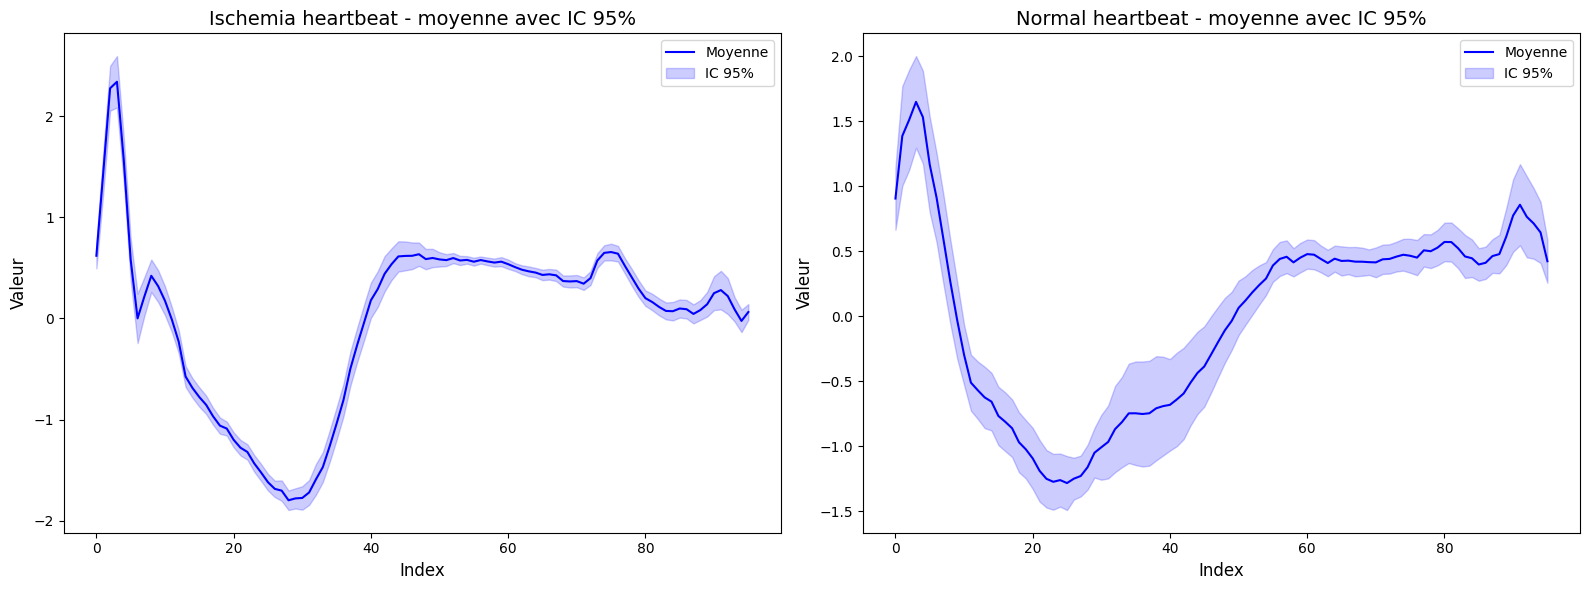

In [3]:
df0 = X_train[X_train["label"]==-1].iloc[:, :-1]
df1 = X_train[X_train["label"]==1].iloc[:, :-1]
utils.plot_classes(df0, df1, num_seg=None)

On aperçoit au vu de ces deux figures que les éléments caractéristiques d'un rythme cardiaque anormal et la présence d'un petit pic à environ $t=10$. Ou encore un pic d'une amplitude plus importante à la fin de la série. Cette première comparaison va, on l'espère, nous permettre de souligner les limites de la méthode SAX qui ne capte pas ces mouvements d'amplitude. Cette limite a notamment été corrigée dans l'approche [ESAX](https://dl.acm.org/doi/10.1109/ICDEW.2006.99) laquelle produit une symbolisation trois fois plus longue car celle-ci produit une symbolisation de la série à partir d'un triplet $(min, mean, max)$ par segment. 

----------------------------------------------------------------------------------------------------------------------------------------------
### Différentes approches pour la symbolisation 

A l'occasion de ce projet, nous allons comparer différentes méthodes de symbolisation de séries temporelles. Il existe beaucoup de littérature autour de ce procédé et de nombreuses méthodes, toutes plus inventives les unes des autres, ont émergé à ce sujet. La symbolisation consiste en la transformation d'une série temporelles de taille $N$, dont les valeurs évoluent dans un espace continu (souvent $\mathbb{R}$ pour des séries univariées), en un "mot" de taille $k << N$ formé à partir d'un alphabet de symboles fini de taille $A$. L'objectif de ce procédé étant de réduire massivement l'espace de stockage qu'occupe une série temporelle symbolisée, tout en perdant le moins possible d'information au sujet de cette série. Il existe plusieurs approches pour la symbolisation, chacune ayant des avantages et des inconvénients, que nous allons comparer pour les tâches de classification, clustering et indexation. Pour que la comparaison soit équitable, on observera à quel point est ce que les méthodes sont performantes pour ses tâches pour un alphabet donné, et une taille de mot donnée. 

Les méthodes que nous étudions sont les suivantes : 
- SAX (Symbolic Aggregate approXimation)
- ESAX (Extended SAX)
- TSAX (Trend SAX)
- 1D-SAX (One-Dimensional SAX)
- ASTRIDE (Adaptive Symbolic Time-series Representation for Indexing and DEnsity estimation)
- SFA (Symbolic Fourier Approximation) 
- BOSS (Bag of SFA Symbols) 

Les méthodes SAX, ESAX, TSAX, et 1D-SAX s'appuient sur la représentation PAA (Piecewise Aggregate Approximation). Cette technique divise la série temporelle en segments de taille égale, sur lesquels la série est approximée par une valeur constante correspondant à la moyenne des valeurs du segment. Une fois la PAA obtenue, on suppose que les valeurs de la série sont distribuées selon une loi normale centrée réduite. Cela permet de diviser l'espace des valeurs en plusieurs intervalles (ou bins), définis de manière à ce que chaque bin représente une aire égale sous la courbe de densité gaussienne. Pour SAX, chaque bin est associé à une lettre de l'alphabet, et la série est ensuite encodée en attribuant à chaque segment la lettre correspondant au bin où se situe sa moyenne. 

Les 3 autres méthodes capturent davantage d'information mais parfois au détriment de la compression de l'information. Sur chacun des segments, ESAX encode la valeur du minimum et maximum atteint par la série, ce traduisant par un mot 3 fois plus long que SAX pour un même nombre de segments et taille d'alphabet. TSAX ... Tandis que 1D-SAX encode la moyenne et la pente de la série sur chacun des segments dans leur alphabet respectif avant d'unir chaque association de symboles par un unique. Ainsi, la taille de l'alphabet peut vite croître rendant moins intéressante la méthode en terme de compression mais plus précise en terme d'approximation. 

Les méthodes SFA et BOSS reposent sur la symbolisation de la série dans l'espace des fréquences. En effet, elles analysent les caractéristiques des données temporelles à l'aide de la transformée de Fourier discrète (DFT), afin de capturer des informations pertinentes sur les motifs et les distributions des fréquences présentes dans la série temporelle. Cela permet une meilleure représentation des données tout en réduisant leur complexité, tout en maintenant une bonne fidélité dans la capture des informations essentielles pour les tâches de classification, de détection de tendances ou de détection de motifs. Les composantes spectrales portant le plus d'information sont sélectionnées à l'échelle de la database et un alphabet spécifique leur est associé. 

Enfin, l'innovation apportée par ASTRIDE est double puisqu'elle survient au moment de la segmentation de la série et de la création de l'alphabet. En effet, la segmentation de la série est adaptative et se fait par détection de change-points (souvent sur un critère de moyenne) à l'échelle de la database entière. C'est-à-dire que la segmentation qui fait le plus de sens pour l'ensemble des séries est conservée. Ainsi, elle repose sur le même principe que SAX mais les bins associées aux différentes lettres sont créées à partir des quantiles empiriques des moyennes sur chaque segment, de l'ensemble des séries de la database. Ce qui tient donc davantage compte des données que la méthode SAX pour une compression égale de l'information. 

Voici un résumé succint des principales caractéristiques et fonctionnement de ces méthodes : 

| **Feature**                       | **SAX**                              | **ESAX**                             | **TSAX**                              | **1D-SAX**                          | **ASTRIDE**                        | **SFA**                             | **BOSS**                            |
|-----------------------------------|---------------------------------------|---------------------------------------|----------------------------------------|--------------------------------------|-------------------------------------|--------------------------------------|--------------------------------------|
| **Segmentation**                 | Uniform                              | Uniform                              | Uniform                               | Uniform                              | Adaptive                           | Uniform                             | Sliding window                      |
| **Representation**               | Symbols via means                    | Symbols via means + min and max      | Symbols based on trends               | Symbols combining mean and slope    | Mean-based symbol                  | Symbols via frequency spectrum      | Histogram of SFA words in the sliding window |
| **Data compression**             | High                                 | Medium                               | Medium                                | Low                                  | High                               | Medium                             | Medium                             |
| **Resistance to variations**     | Low                                  | Medium                               | High                                  | Medium                               | High                               | Medium                             | Medium                             |
| **Reconstruction fidelity**      | Low                                  | Medium                               | Low                                   | High                                 | Low                                | Medium                             | Low                                |
| **Specific advantages**          | Simplicity and speed                 | Captures local trends                | Focuses on global direction           | Captures more detailed shape        | Captures structured patterns        | Frequency analysis (robustness)    | Statistical analysis of words       |
| **Limitations**                  | Ignores trends and variations        | Increased complexity                 | Ignores exact values                  | Higher complexity                    | Strong dependence on patterns       | Requires FFT                       | Large histogram size                |
| **Distance used**                | MINDIST                            | MINDIST                            | TRENDIST                             | Euclidean Distance between reconstructions                            | D-GEN             | Euclidian Distance between Average Discrete Fourier Coefficients                | BOSS Metric from PYTS            |

----------------------------------------------------------------------------------------------------------------------------------------------
### Présentation des méthodes

Pour chacune des méthodes employées, on explique brièvement les étapes nécessaires à la symbolisation, la distance utilisée pour la comparaison des séries symboliques ainsi que l'évolution de l'accuracy en fonction des paramètres de la méthode. Quand cela est possible, on considérera le problème opposé, c'est-à-dire comment peut on reconstruire le plus précisément possible une approximation de la série temporelle initiale à partir de sa représentation symbolique dans ces différentes méthodes. Nous avons donc construit des fonctions qui permettent de réaliser cette reconstruction pour chacune des méthodes, sauf pour BOSS. En effet, la difficulté varie beaucoup selon les méthodes. Pour SAX et ESAX, on approxime la série par sa valeur moyenne sur chaque segment que l'on retouve à partir des quantiles de la loi normale qui définissent les différentes bins. Pour ASTRIDE, pareil mais les segments sont adaptatifs. 

Pour 1D-SAX, il est possible de retrouver la moyenne et la pente de la série sur chaque segment et d'avoir une approximation linéaire par morceaux de cette série. Enfin pour SFA, on peut retrouver une approximation des coefficients de la DFT à partir des symboles et reconstruire la série de cette manière. 

On choisit la première série temporelle du dataset test comme exemple. 



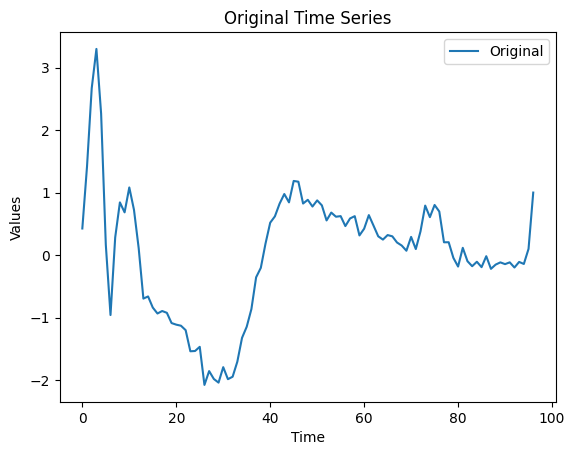

In [3]:
## Preprocessing du Train et Test

X_train_scaled = utils.std_scaler(X_train)
X_test_scaled = utils.std_scaler(X_test)

TS_test = X_test.iloc[0]

plt.plot(np.array(TS_test), label="Original")
plt.title("Original Time Series")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

#### SAX

On compare pour une segmentation de 10 ou 20 et une taille d'alphabet de 4 ou 8 la représentation SAX de la série. 

In [59]:
SAX_1 = SAX_transform(np.array(TS_test), 10, 4)
SAX_symb_1 = SAX_1.calculate_sax()
print(f'La version SAX de la série est : {SAX_symb_1}, pour 10 segments et 4 symboles possibles')

SAX_2 = SAX_transform(np.array(TS_test), 20, 4)
SAX_symb_2 = SAX_2.calculate_sax()
print(f'La version SAX de la série est : {SAX_symb_2}, pour 20 segments et 4 symboles possibles')

SAX_3 = SAX_transform(np.array(TS_test), 10, 8)
SAX_symb_3 = SAX_3.calculate_sax()
print(f'La version SAX de la série est : {SAX_symb_3}, pour 10 segments et 8 symboles possibles')

SAX_4 = SAX_transform(np.array(TS_test), 20, 8)
SAX_symb_4 = SAX_4.calculate_sax()
print(f'La version SAX de la série est : {SAX_symb_4}, pour 20 segments et 8 symboles possibles')


La version SAX de la série est : dbaacdcccb, pour 10 segments et 4 symboles possibles
La version SAX de la série est : dcdbaaaaabdddccccccc, pour 20 segments et 4 symboles possibles
La version SAX de la série est : hdaaegfefd, pour 10 segments et 8 symboles possibles
La version SAX de la série est : hfgcbaaaacgggfffeefe, pour 20 segments et 8 symboles possibles


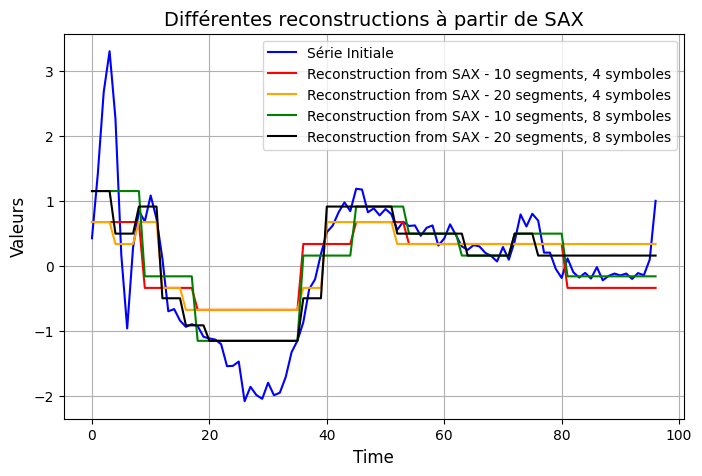

In [61]:
reconstruct_SAX_1 = SAX_1.reconstruction_from_sax(SAX_symb_1)
reconstruct_SAX_2 = SAX_2.reconstruction_from_sax(SAX_symb_2)
reconstruct_SAX_3 = SAX_3.reconstruction_from_sax(SAX_symb_3)
reconstruct_SAX_4 = SAX_4.reconstruction_from_sax(SAX_symb_4)

plt.figure(figsize=(8, 5))
plt.plot(np.array(TS_test), color='blue', label="Série Initiale")
plt.plot(reconstruct_SAX_1, color='red', label="Reconstruction from SAX - 10 segments, 4 symboles")
plt.plot(reconstruct_SAX_2, color='orange', label="Reconstruction from SAX - 20 segments, 4 symboles")
plt.plot(reconstruct_SAX_3, color='green', label="Reconstruction from SAX - 10 segments, 8 symboles")
plt.plot(reconstruct_SAX_4, color='black', label="Reconstruction from SAX - 20 segments, 8 symboles")
plt.title("Différentes reconstructions à partir de SAX", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Valeurs", fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.show()


In [ ]:
### NE PAS RUN CETTE CELLULE ###
### NP.LOAD LE VECTEUR PLUTÔT ###

accuracies = np.zeros((18,8))

for i in range(2, 20): 
    for j in range(2, 10): 

        KNN_MODEL = SYMBOLS(
                    X_train, 
                    X_test, 
                    'SAX', 
                    num_segments=i, 
                    alphabet_size=j)
        KNN_MODEL._predict()
        accuracies[i-2, j-2] = KNN_MODEL.accuracy

np.save("accuracies.npy", accuracies)

Voici les reconstructions que l'on peut faire à partir de ces représentations symboliques: 

Performance de la classification de SAX pour différentes valeurs du paramètre : KNN avec 1 plus proche voisin. 

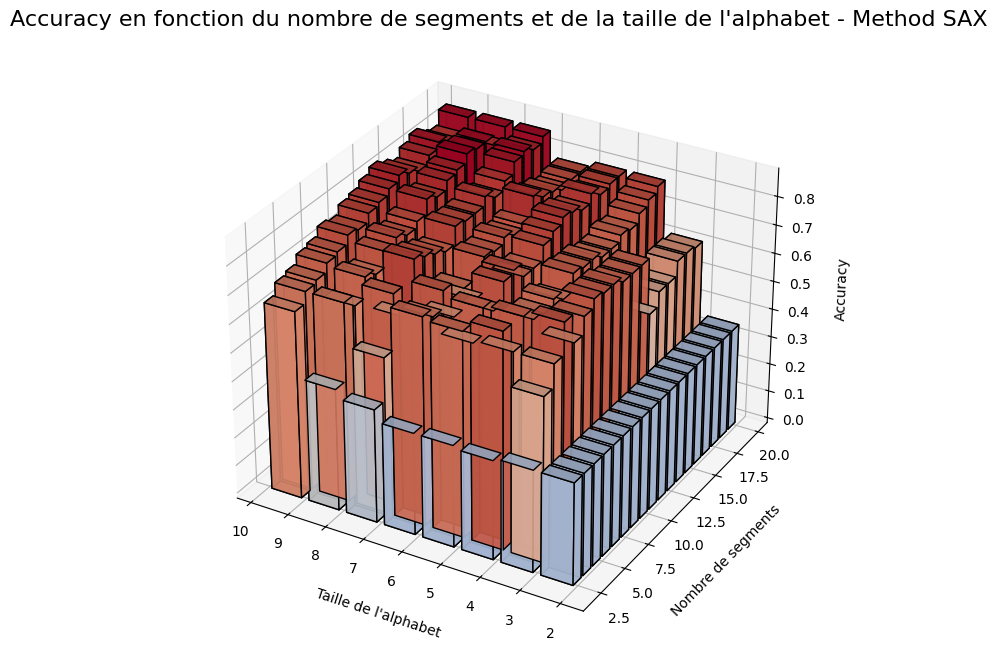

In [5]:
accuracies = np.load('accuracies/accuracies.npy')

plot_3D(np.arange(2, 10), np.arange(2, 20), accuracies, 
        "Accuracy en fonction du nombre de segments et de la taille de l'alphabet - Method SAX", 'Taille de l\'alphabet', 
        'Nombre de segments', 'Accuracy') 

#### ESAX

On fait de même pour ESAX, qui encode davantage d'informations sur chaque segment par rapport à SAX, à savoir la valeur symbolique du minimum et maximum de la série sur le segment. Ainsi, on remarque que sa représentation symbolique compresse moins l'information (3x plus de symboles pour un même nombre de segments). Mais on peut s'attendre à observer des performances de classification supérieure à SAX. 

Concernant la reconstruction, elle n'est elle pas fondamentalement différente de SAX puisque la connaissance du minimum et maximum donne une idée de l'étendue des données sur le segments, mais qui n'est pas vraiment exploitable pour la reconstruction. 

On compare de la même façon ESAX avec plusieurs valeurs des paramètres, à savoir le nombre de segments et la taille de l'alphabet. 

In [73]:
SAX_1 = SAX_transform(np.array(TS_test), 10, 4)
SAX_symb_1 = SAX_1.calculate_esax()
print(f'La version ESAX de la série est : {SAX_symb_1}, pour 10 segments et 4 symboles possibles')

SAX_2 = SAX_transform(np.array(TS_test), 20, 4)
SAX_symb_2 = SAX_2.calculate_esax()
print(f'La version ESAX de la série est : {SAX_symb_2}, pour 20 segments et 4 symboles possibles')

SAX_3 = SAX_transform(np.array(TS_test), 10, 8)
SAX_symb_3 = SAX_3.calculate_esax()
print(f'La version ESAX de la série est : {SAX_symb_3}, pour 10 segments et 8 symboles possibles')

SAX_4 = SAX_transform(np.array(TS_test), 20, 8)
SAX_symb_4 = SAX_4.calculate_esax()
print(f'La version ESAX de la série est : {SAX_symb_4}, pour 20 segments et 8 symboles possibles')


La version ESAX de la série est : addabdaaaaaaacdcddccccccbcdbbd, pour 10 segments et 4 symboles possibles
La version ESAX de la série est : cddacddddabcaaaaaaaaaaaaaaaabccddddddddcccccccccccccccccdbcd, pour 20 segments et 4 symboles possibles
La version ESAX de la série est : bhhbdgaabaaabegfgheffeeedfgddg, pour 10 segments et 8 symboles possibles
La version ESAX de la série est : fhhbfhgggbcebbbaabaaaaaaaaabcefgggghgggfffeffeffeeeeeeffgdeg, pour 20 segments et 8 symboles possibles


In [ ]:
### NE PAS RUN CETTE CELLULE CAR TROP LONGUE ###
### CHARGER LE VECTEUR D'ACCURACIES DIRECTEMENT ###
accuracies_esax = np.zeros((18,8))

for i in range(2, 20): 
    for j in range(2, 10): 

        KNN_MODEL = SYMBOLS(
                    X_train, 
                    X_test, 
                    'ESAX', 
                    num_segments=i, 
                    alphabet_size=j)
        KNN_MODEL._predict()
        accuracies_esax[i-2, j-2] = KNN_MODEL.accuracy

np.save("accuracies_esax.npy", accuracies_esax)

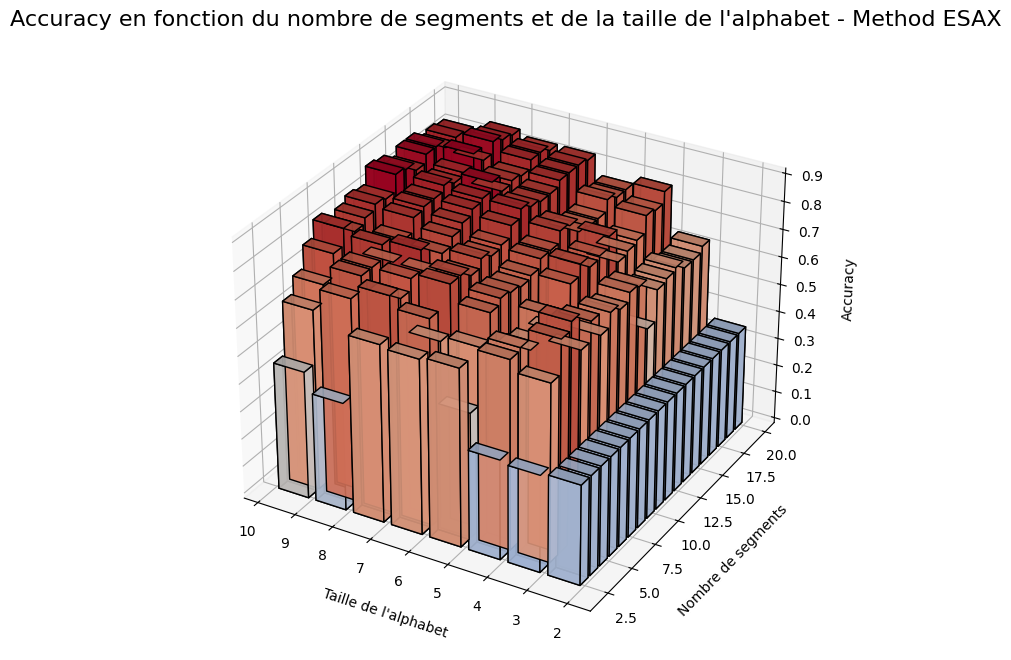

In [ ]:
accuracie_esax = np.load('accuracies/accuracies_esax.npy')

plot_3D(np.arange(2, 10), np.arange(2, 20), accuracies, 
        "Accuracy en fonction du nombre de segments et de la taille de l'alphabet - Method ESAX", 'Taille de l\'alphabet', 
        'Nombre de segments', 'Accuracy') 

En particulier, pour une taille d'alphabet similaire, ESAX encode 3 fois plus de symboles pour un même nombre de segments. Ce qui se traduit par de meilleures performances de classification par rapport à SAX mais pas significatives. 

Exemple pour 10 segments et on fait varier la taille de l'alphabet : 

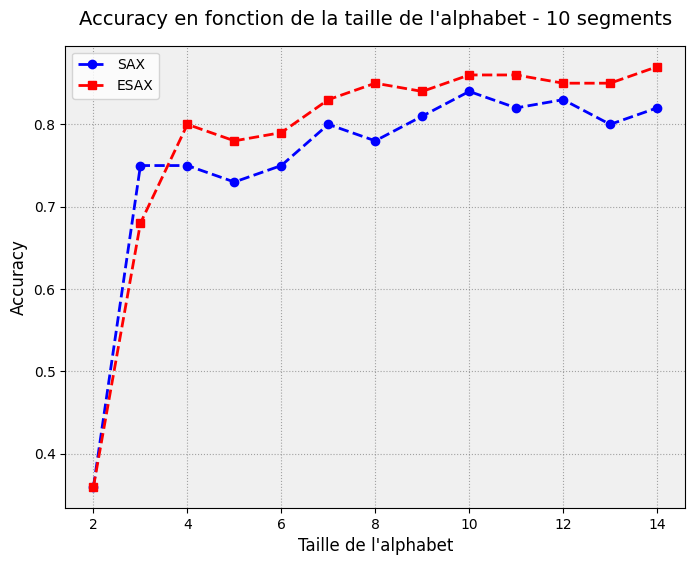

In [79]:
#sax_acc = np.load('sax_acc.npy')
#esax_acc = np.load('esax_acc.npy')

abs_x = range(2, 15)

plt.figure(figsize=(8, 6))
plt.plot(abs_x, sax_acc, color='blue', marker='o', linestyle='--', linewidth=2, label="SAX")
plt.plot(abs_x, esax_acc, color='red', marker='s', linestyle='--', linewidth=2, label="ESAX")

plt.gca().set_facecolor('#f0f0f0')

plt.title("Accuracy en fonction de la taille de l'alphabet - 10 segments", fontsize=14, pad=15)
plt.xlabel("Taille de l'alphabet", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.grid(True, linestyle=':', linewidth=0.8, color='gray', alpha=0.7)
plt.legend(loc='best', fontsize=10)
plt.show()
    

#### TSAX

Cette méthode est légèrement différente puisqu'elle encode à fois la moyenne et la tendance de la série sur chaque segment. (...)

On fixe la valeur de l'alphabet des angles à 5 et l'on fait varier la taille de la segmentation et de l'alphabet des moyennes. 

In [72]:
SAX_1 = SAX_transform(np.array(TS_test), 10, 4)
SAX_symb_1 = SAX_1.calculate_tsax(5)
print(f'La version TSAX de la série est : {SAX_symb_1}, pour 10 segments et 4 symboles possibles')

SAX_2 = SAX_transform(np.array(TS_test), 20, 4)
SAX_symb_2 = SAX_2.calculate_tsax(5)
print(f'La version TSAX de la série est : {SAX_symb_2}, pour 20 segments et 4 symboles possibles')

SAX_3 = SAX_transform(np.array(TS_test), 10, 8)
SAX_symb_3 = SAX_3.calculate_tsax(5)
print(f'La version TSAX de la série est : {SAX_symb_3}, pour 10 segments et 8 symboles possibles')

SAX_4 = SAX_transform(np.array(TS_test), 20, 8)
SAX_symb_4 = SAX_4.calculate_tsax(5)
print(f'La version TSAX de la série est : {SAX_symb_4}, pour 20 segments et 8 symboles possibles')


La version TSAX de la série est : deadbbdcacccacccccccdbcccccccccccbccbcdd, pour 10 segments et 4 symboles possibles
La version TSAX de la série est : dccdccaddcbcbdccacccacccabdcacccacccbbcddcccdbbbdccccccccccccbcccccccccccbdccddc, pour 20 segments et 4 symboles possibles
La version TSAX de la série est : headdbdcacccacccecccgbccfcccecccfbccdcdd, pour 10 segments et 8 symboles possibles
La version TSAX de la série est : hccdfcadgcbccdccbcccacccabdcacccaccccbcdgcccgbbbgcccfcccfcccfbccecccecccfbdceddc, pour 20 segments et 8 symboles possibles


#### 1D-SAX

Sur chaque segment, on définit de manière unique chaque association de 2 symboles encodant la moyenne et la pente de la régression linéaire de la série sur le temps. Pour encoder ces deux quantités, on utilise 2 alphabets distincts ce qui fait augmenter très vite la taille de l'alphabet total.  A partir de cet encodage unique, on peut effectuer l'opération inverse et de retrouver la valeur moyenne de la série ainsi que sa pente sur chaque segment, ce qui nous permet de reconstruire une approximation de la série initiale, linéaire par morceaux. 

D'une manière analogue à TSAX, on fixe à 4 la longueur de l'alphabet des pentes, on peut faire varier la taille de la segmentation et de l'alphabet.  

In [15]:
SAX_1 = SAX_transform(np.array(TS_test), 10, alphabet_size=4)
SAX_symb_1 = SAX_1.transf_1d_sax(4, 4)
print(f'La version 1D-SAX de la série est : {SAX_symb_1}, pour 10 segments et 4 symboles possibles')

SAX_2 = SAX_transform(np.array(TS_test), 20, alphabet_size=4)
SAX_symb_2 = SAX_2.transf_1d_sax(4, 4)
print(f'La version 1D-SAX de la série est : {SAX_symb_2}, pour 20 segments et 4 symboles possibles')

SAX_3 = SAX_transform(np.array(TS_test), 10, alphabet_size=4)
SAX_symb_3 = SAX_3.transf_1d_sax(8, 4)
print(f'La version 1D-SAX de la série est : {SAX_symb_3}, pour 10 segments et 8 symboles possibles')

SAX_4 = SAX_transform(np.array(TS_test), 20, alphabet_size=4)
SAX_symb_4 = SAX_4.transf_1d_sax(8, 4)
print(f'La version 1D-SAX de la série est : {SAX_symb_4}, pour 20 segments et 8 symboles possibles')


La version 1D-SAX de la série est : [12, 4, 0, 3, 11, 12, 9, 9, 8, 6], pour 10 segments et 4 symboles possibles
La version 1D-SAX de la série est : [15, 8, 14, 4, 0, 0, 0, 2, 3, 7, 15, 13, 13, 10, 8, 8, 9, 10, 11, 9], pour 20 segments et 4 symboles possibles
La version 1D-SAX de la série est : [28, 12, 0, 3, 19, 24, 21, 17, 20, 14], pour 10 segments et 8 symboles possibles
La version 1D-SAX de la série est : [31, 20, 26, 8, 4, 0, 0, 2, 3, 15, 27, 25, 25, 22, 20, 20, 17, 18, 23, 17], pour 20 segments et 8 symboles possibles


Reconstruction d'une approximation de la série originale à partir des différentes représentations

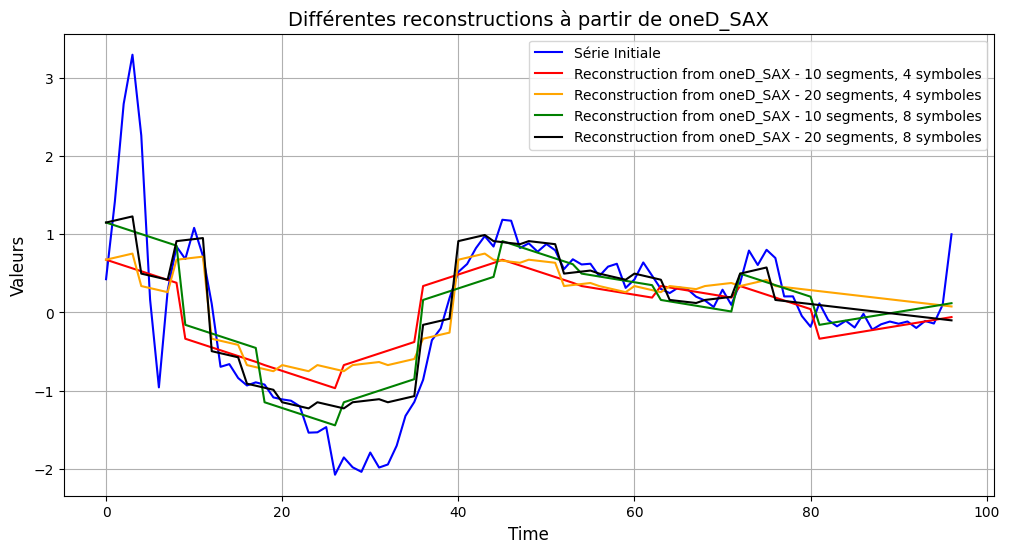

In [16]:
reconstruct_SAX_1 = SAX_1.reconstruct_from_1d_sax(SAX_symb_1, 4, 4)
reconstruct_SAX_2 = SAX_2.reconstruct_from_1d_sax(SAX_symb_2, 4, 4)
reconstruct_SAX_3 = SAX_3.reconstruct_from_1d_sax(SAX_symb_3, 8, 4)
reconstruct_SAX_4 = SAX_4.reconstruct_from_1d_sax(SAX_symb_4, 8, 4)

plot_recons(np.array(TS_test), reconstruct_SAX_1, reconstruct_SAX_2, reconstruct_SAX_3, reconstruct_SAX_4, 'oneD_SAX')

Concernant la classification à l'aide de 1D-SAX, la question de la distance à utiliser se pose puisque dans l'article introductif de la méthode, aucune distance n'est présentée qui permettrait de mesurer la similarité entre 2 séquences symboliques. En effet, la seule distance introduite permet de comparer une série temporelle brute (non-symbolisée) contre une série symbolisée. Nous avons donc pris le parti d'adapter cette distance à deux séries symboliques. Pour se faire, on utilise la distance euclidienne en les 2 reconstructions des séries symbolisées. 

Voici les résultats d'accuracy pour ce dataset, avec une segmentation de 10, une taille d'alphabet de 4 ou 8 pour les moyennes et 4 pour les pentes. 

A titre expérimental, on teste la classification à partir des représentations 1D-SAX et la distance MINDIST

### ASTRIDE

Comme mentionné précédemment, ASTRIDE utilise la même symbolisation que SAX sur les moyennes de la séries sur les différents segments. Néanmoins, la segmentation est adaptative fondée sur la détection des change points. Elle est commune à l'ensemble du dataset et les bins qui séparent les différents symboles sont calculés via les quantiles des moyennes des séries du dataset sur chacun des segments. 

Pour le dataset de train et une segmentation de taile 15, on trace les différentes séparations communes à toutes les séries du dataset. Puis, on montre la symbolisation et la reconstruction faite à partir de la méthode pour différentes valeurs des paramètres. 


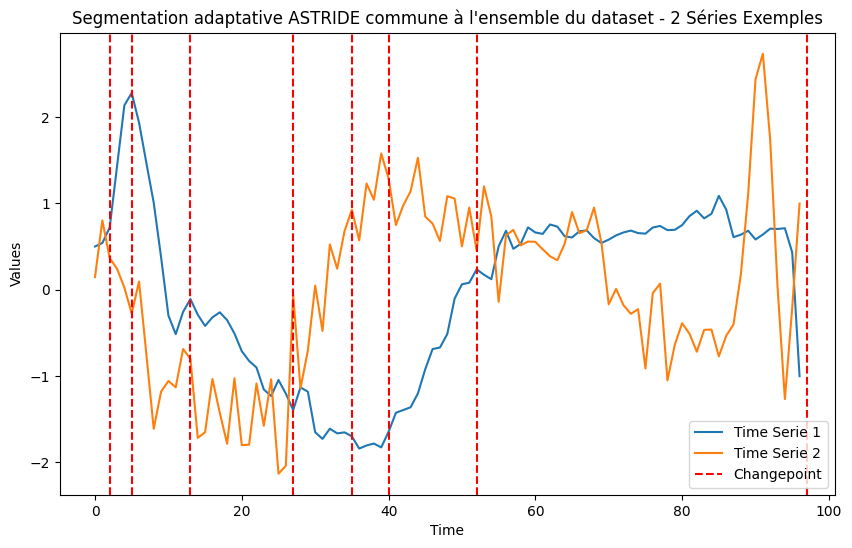

In [7]:
astride = ASTRIDE_transf(np.array(X_train), 8, 5)
astride.mts_bkps_

ex_serie_1 = np.array(X_train.iloc[0])
ex_serie_2 = np.array(X_train.iloc[1])

plt.figure(figsize=(10, 6))
plt.plot(ex_serie_1, label='Time Serie 1')
plt.plot(ex_serie_2, label='Time Serie 2')

# Ajout des changepoints (mts_bkps_)
for cp in astride.mts_bkps_:
    plt.axvline(x=cp, color='red', linestyle='--', label='Changepoint' if 'Changepoint' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.title("Segmentation adaptative ASTRIDE commune à l'ensemble du dataset - 2 Séries Exemples")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [8]:
ASTRIDE_1 = ASTRIDE_transf(np.array(X_train), 10, 4)
ASTRIDE_1._ASTRIDE_symbolize()
ASTRIDE_symb_1 = ASTRIDE_1.symbolic_data[0]
print(f'La version ASTRIDE de la série est : {ASTRIDE_symb_1}, pour 10 segments et 4 symboles possibles')

ASTRIDE_2 = ASTRIDE_transf(np.array(X_train), 20, 4)
ASTRIDE_2._ASTRIDE_symbolize()
ASTRIDE_symb_2 = ASTRIDE_2.symbolic_data[0]
print(f'La version ASTRIDE de la série est : {ASTRIDE_symb_2}, pour 20 segments et 4 symboles possibles')

ASTRIDE_3 = ASTRIDE_transf(np.array(X_train), 10, 8)
ASTRIDE_3._ASTRIDE_symbolize()
ASTRIDE_symb_3 = ASTRIDE_3.symbolic_data[0]
print(f'La version ASTRIDE de la série est : {ASTRIDE_symb_3}, pour 10 segments et 8 symboles possibles')

ASTRIDE_4 = ASTRIDE_transf(np.array(X_train), 20, 8)
ASTRIDE_4._ASTRIDE_symbolize()
ASTRIDE_symb_4 = ASTRIDE_4.symbolic_data[0]
print(f'La version ASTRIDE de la série est : {ASTRIDE_symb_4}, pour 20 segments et 8 symboles possibles')


La version ASTRIDE de la série est : DDBBAAACC, pour 10 segments et 4 symboles possibles
La version ASTRIDE de la série est : DDDDBBAAAAAABCDDDDB, pour 20 segments et 4 symboles possibles
La version ASTRIDE de la série est : HHDCAABFF, pour 10 segments et 8 symboles possibles
La version ASTRIDE de la série est : HHHGCCBBAAABDFGGGGC, pour 20 segments et 8 symboles possibles


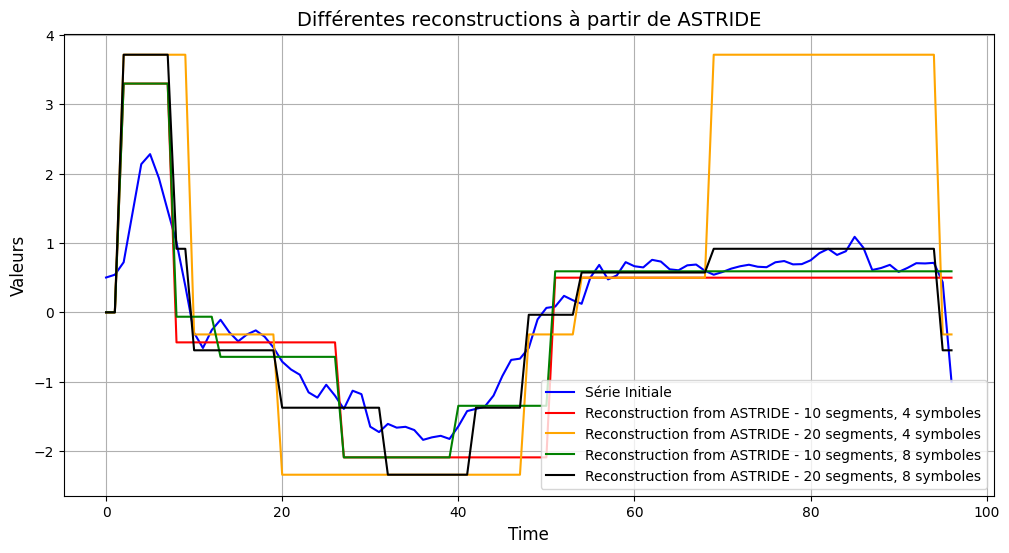

In [13]:
reconstruct_ASTRIDE_1 = ASTRIDE_1.reconstruction_from_ASTRIDE(ASTRIDE_1.symbolic_data)
reconstruct_ASTRIDE_2 = ASTRIDE_2.reconstruction_from_ASTRIDE(ASTRIDE_2.symbolic_data)
reconstruct_ASTRIDE_3 = ASTRIDE_3.reconstruction_from_ASTRIDE(ASTRIDE_3.symbolic_data)
reconstruct_ASTRIDE_4 = ASTRIDE_4.reconstruction_from_ASTRIDE(ASTRIDE_4.symbolic_data)

plot_recons(X_train.iloc[0], reconstruct_ASTRIDE_1[0], reconstruct_ASTRIDE_2[0], reconstruct_ASTRIDE_3[0], reconstruct_ASTRIDE_4[0], "ASTRIDE")

---------------------------------------------------------------------------------------------------------------------------------------------

### Benchmark Classification

Dans cette partie, on s'attèle à la comparaison des différentes méthodes de symbolisation pour ce qui est de la tâche de classification. On ajoute les méthodes SFA et BOSS à notre benchmark et l'on fixe le nombre de segments à 10. 

Dans cette expérience, on fait varier la taille des alphabets et l'on compare les performances des algorithmes en terme d'accuracy sur le dataset de TEST. Et on comparera les performances de ces méthodes aux méthodes usuelles de classifications sur les séries brutes, à savoir les KNNs avec la distance euclidiennes ou DTW. On sera donc en mesure d'avoir une idée de la perte d'efficacité provenant de la compression de l'information. 

PS: Effectivement, pour certaines méthodes comme TSAX, la taille de l'alphabet est fixé pour les angles et varie pour les moyennes. Ainsi, cela n'est pas parfaitement équitable avec les autres méthodes puisque cela permet un nombre de combinaisons beaucoup plus grand avec le même alphabet. On le prendra en compte au moement de l'interprétation des résultats. 

In [4]:
## KNN with Euclidean Distance on Row Time Series

X_train_ts = to_time_series_dataset(X_train)
X_test_ts = to_time_series_dataset(X_test)

knn_euc = KNeighborsTimeSeriesClassifier(metric='euclidean', n_jobs=-1)

k_grid = {
    'n_neighbors' : range(1, 11)
}

grid_search = GridSearchCV(
            estimator=knn_euc, 
            param_grid=k_grid, 
            scoring='f1', #make_scorer(f1_score),
            cv=5,
            n_jobs=-1, 
            verbose=1)

grid_search.fit(X_train_ts, y_train)

print(f"Meilleur K: {grid_search.best_params_['n_neighbors']} avec un F-score de {grid_search.best_score_:.4f}")

predictor = grid_search.best_estimator_
y_pred = predictor.predict(X_test_ts)
y_scores = predictor.predict_proba(X_test_ts)[:, 1]
KNN_euc = accuracy_score(y_test, y_pred)

print(f"Accuracy des 1-NN sur les séries brutes avec distance euclidienne sur le dataset de test: {KNN_euc:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Meilleur K: 1 avec un F-score de 0.9501
Accuracy des 1-NN sur les séries brutes avec distance euclidienne sur le dataset de test: 0.9400


Pareil avec la DTW: 

In [5]:
knn_dtw = KNeighborsTimeSeriesClassifier(metric='dtw', n_jobs=-1)

k_grid = {
    'n_neighbors' : range(1, 11)
}

grid_search = GridSearchCV(
            estimator=knn_dtw, 
            param_grid=k_grid, 
            scoring='f1', #make_scorer(f1_score),
            cv=5,
            n_jobs=-1, 
            verbose=1)

grid_search.fit(X_train_ts, y_train)

print(f"Meilleur K: {grid_search.best_params_['n_neighbors']} avec un F-score de {grid_search.best_score_:.4f}")

predictor = grid_search.best_estimator_
y_pred = predictor.predict(X_test_ts)
y_scores = predictor.predict_proba(X_test_ts)[:, 1]

KNN_dtw = accuracy_score(y_test, y_pred)
print(f"Accuracy de notre modèle sur le dataset de test: {KNN_dtw:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleur K: 1 avec un F-score de 0.9931
Accuracy de notre modèle sur le dataset de test: 0.9900


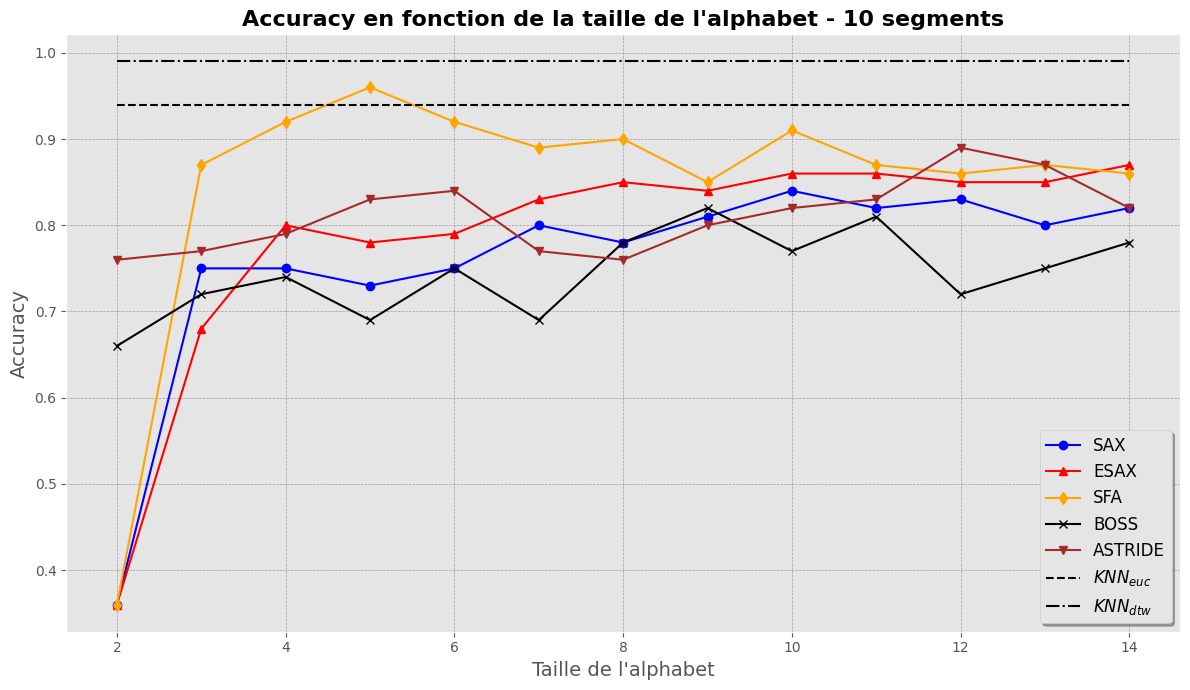

In [14]:
## AVANT DE LES ENREGISTRER, ON CALCULE LES VECTEURS D'ACCURACIES AVEC LA FONCTION SUIVANTE: 
#utils.plot_KNN_accuracies(X_train, X_test)

sax_acc = np.load('accuracies/sax_acc.npy')
esax_acc = np.load('accuracies/esax_acc.npy')
#tsax_acc = np.load('accuracies/tsax_acc.npy')
#oneD_sax_acc = np.load('accuracies/oneD_sax_acc.npy')
sfa_acc = np.load('accuracies/sfa_acc.npy')
boss_acc = np.load('accuracies/boss_acc.npy')
astride_acc = np.load('accuracies/astride_acc.npy')

abs_x = range(2, 15)
plt.figure(figsize=(12, 7))
plt.style.use('ggplot') 

plt.plot(abs_x, sax_acc, color='blue', marker='o', label="SAX")
plt.plot(abs_x, esax_acc, color='red', marker='^', label="ESAX")
#plt.plot(abs_x, tsax_acc, color='green', marker='s', label="TSAX")
plt.plot(abs_x, sfa_acc, color='orange', marker='d', label="SFA")
plt.plot(abs_x, boss_acc, color='black', marker='x', label="BOSS")
plt.plot(abs_x, astride_acc, color='brown', marker='v', label="ASTRIDE")

plt.plot(abs_x, [KNN_euc]*13, 'k--', linewidth=1.5, label=r"$KNN_{euc}$")  # Ligne pour KNN_euc
plt.plot(abs_x, [KNN_dtw]*13, 'k-.', linewidth=1.5, label=r"$KNN_{dtw}$")  # Ligne pour KNN_dtw

plt.title("Accuracy en fonction de la taille de l'alphabet - 10 segments", fontsize=16, fontweight='bold')
plt.xlabel("Taille de l'alphabet", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

plt.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()
    

----------------------------------------------------------------------------------------------------------------------------------------------
On cherche donc dans un premier temps à déterminer le nombre de segment à partir duquel on pourra saisir efficacement ce motif caractéristique des rythmes cardiaques anormaux. Plus précisément, l'idée est de trouver une fenêtre suffisamment restreinte pour que le min et le max sur la fenêtre de ce motif saisisse les deux pics à environ $t=10$. On trace ci-dessous les séries hachurées pour $num\_seg \in \{5, 10, 15\}$.

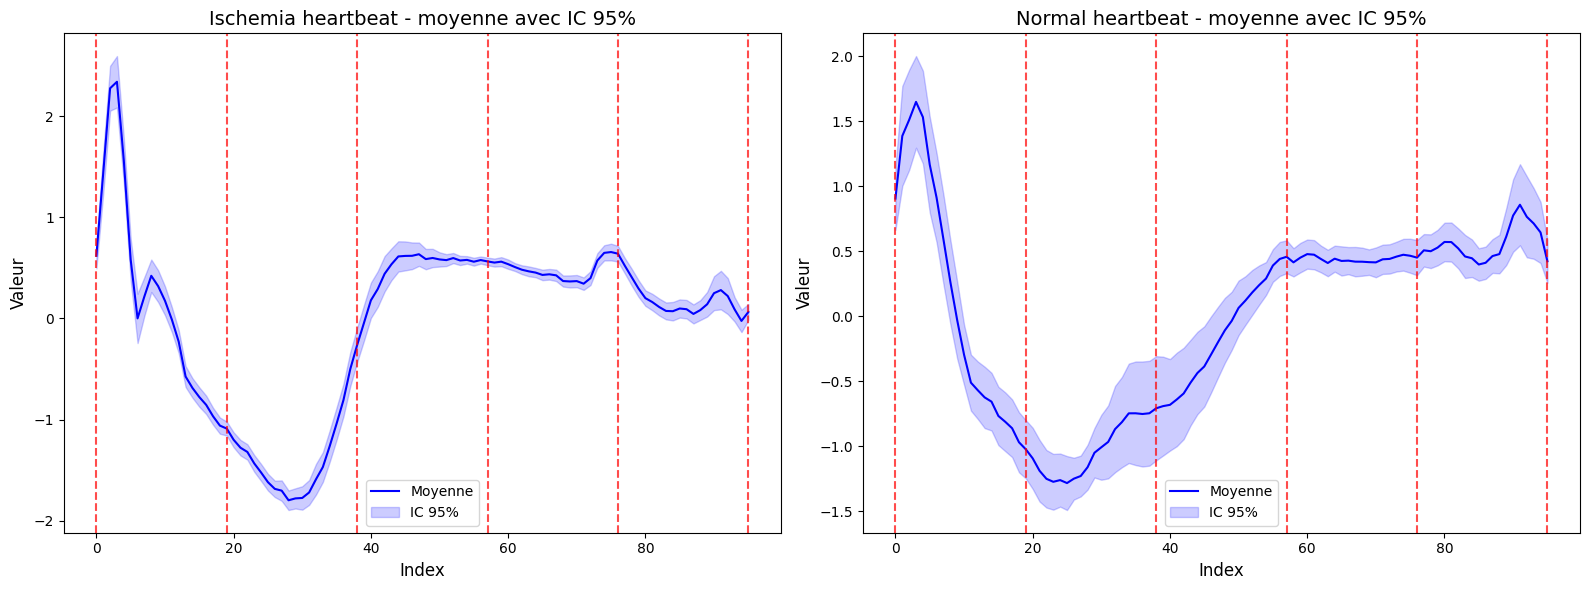

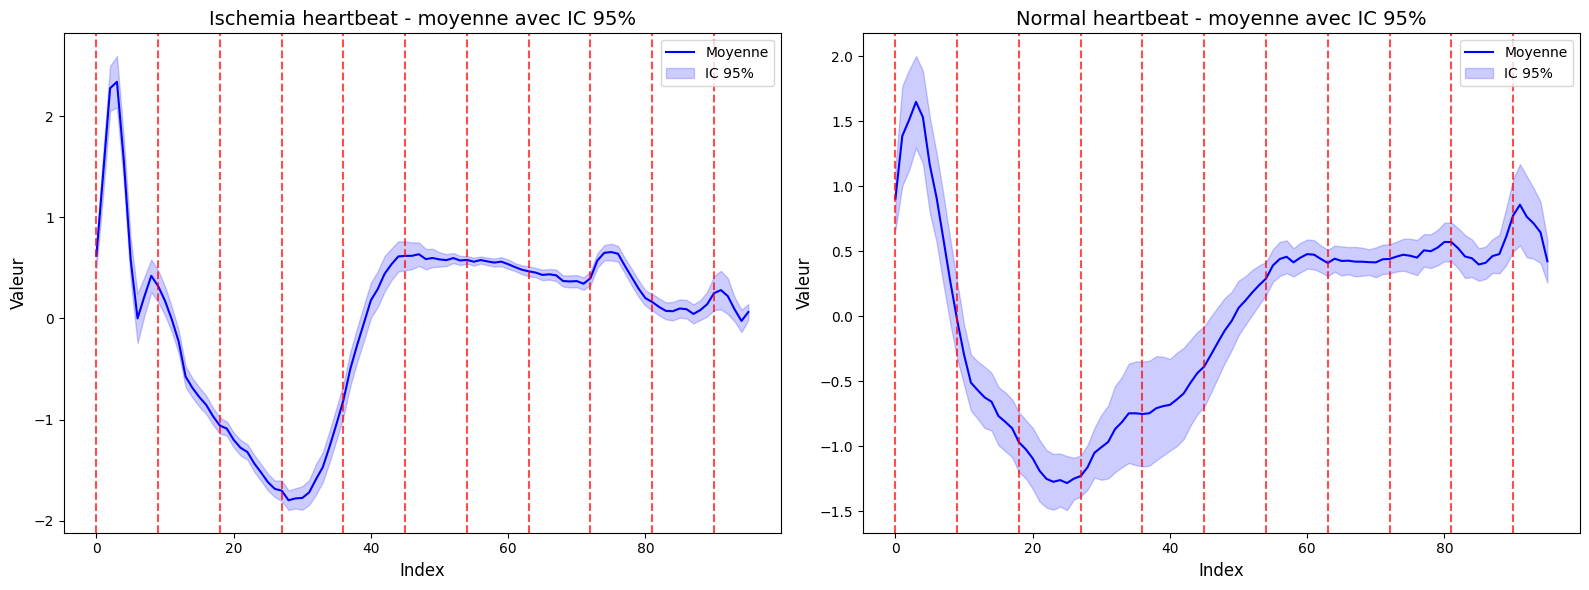

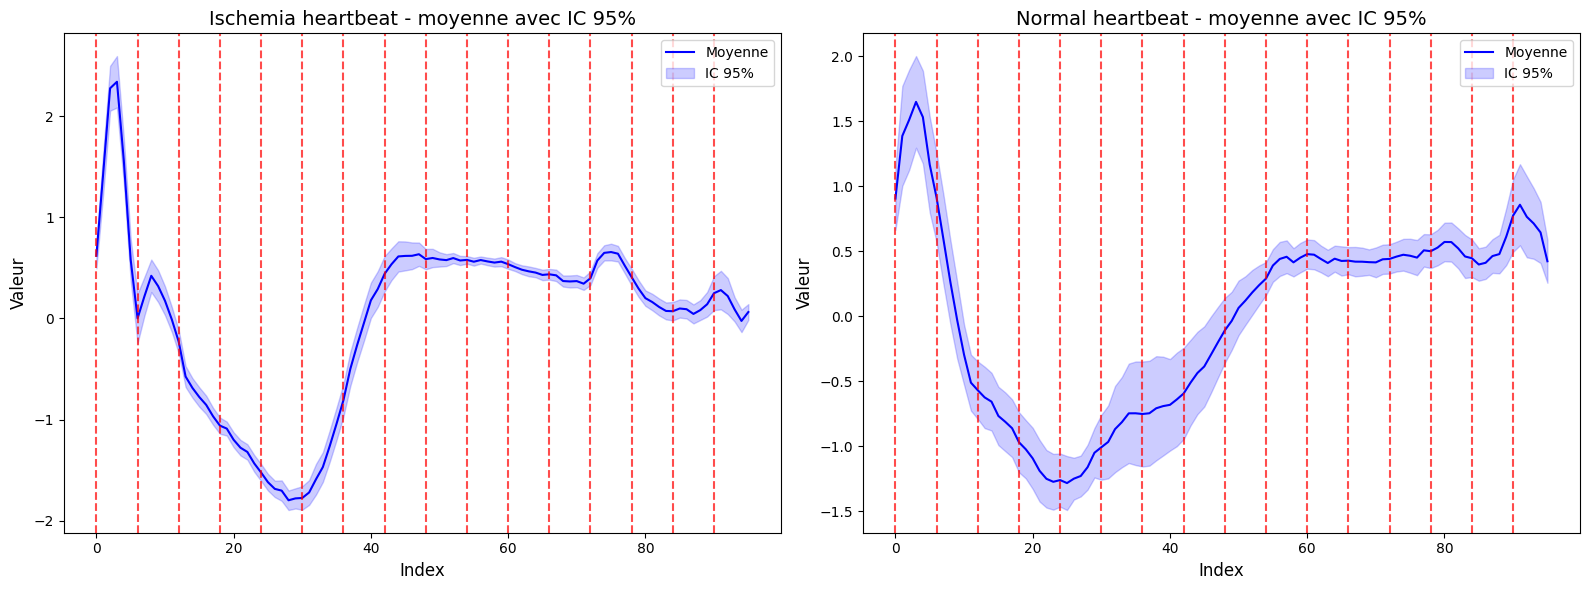

In [10]:
utils.plot_classes(df0, df1, num_seg=5)
utils.plot_classes(df0, df1, num_seg=10)
utils.plot_classes(df0, df1, num_seg=15)

Pour $num\_seg = 15$, on voit qu'entre le second et le troisième trait horizontal, le min et le max est clairement différent. On espère observer une performance significativement supérieure dans la tâche de classification pour $num\_seg=15$ et $num\_seg=5$.

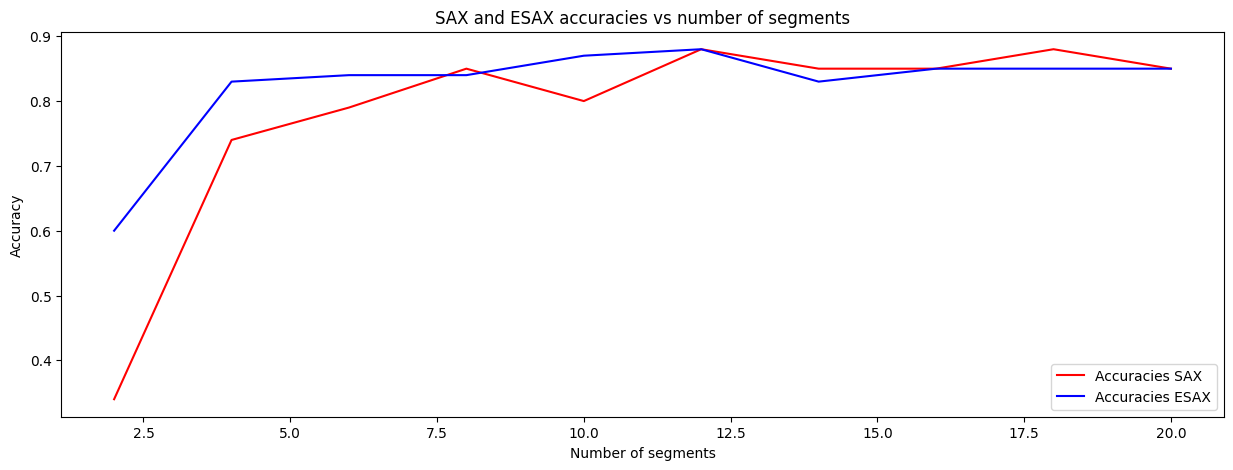

In [18]:

fig, ax = plt.subplots(figsize=(15, 5))
x = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
# Tracé de la première ligne en rouge
ax.plot(x, accuracies_sax, color='red', label='Accuracies SAX')

# Tracé de la deuxième ligne en bleu
ax.plot(x, accuracies_esax, color='blue', label='Accuracies ESAX')

# Ajout des légendes
ax.legend()

# Ajout des titres et étiquettes
ax.set_title("SAX and ESAX accuracies vs number of segments")
ax.set_xlabel("Number of segments")
ax.set_ylabel("Accuracy")

# Affichage de la figure
plt.show()

In [4]:
import sax_clustering 
from Symbol import SYMBOLS

In [15]:
train_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TRAIN.ts")
test_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TEST.ts")

X_train = pd.read_csv(train_path, 
                      sep=",", 
                      header=None
                      )

X_train.columns = list(X_train.columns[:-1]) + ['label']
x_train, y_train = X_train.iloc[:, :-1], X_train["label"]

y_train = y_train.replace(-1, 0)

X_test = pd.read_csv(test_path, 
                      sep=",", 
                      header=None
                      )

X_test.columns = list(X_test.columns[:-1]) + ['label']
x_test, y_test = X_test.iloc[:, :-1], X_test["label"]

y_test = y_test.replace(-1, 0)

In [17]:
SAX_list_k_means_intra_cluster = []
SAX_list_k_means_inter_cluster = []
sax = SYMBOLS(X_train, 
                X_test, 
                'SAX', 
                num_segments=5, 
                alphabet_size=10)

for k in [2, 3, 5, 7, 10]:
    _, _, intra_cluster_mean_distance, inter_cluster_mean_distance = sax_clustering.k_means_sax(sax, 10, 5)
    SAX_list_k_means_inter_cluster.append(inter_cluster_mean_distance)
    SAX_list_k_means_intra_cluster.append(intra_cluster_mean_distance)
    print('*')


*
*
*
*
*


In [ ]:
TSAX_list_k_means_intra_cluster = []
TSAX_list_k_means_inter_cluster = []
tsax = SYMBOLS(X_train, 
               X_test,
               'TSAX', 
               num_segments=5, 
               alphabet_size=10)
for k in [2, 3, 5, 7, 10]:
    _, _, intra_cluster_mean_distance, inter_cluster_mean_distance = sax_clustering.k_means_sax(tsax, 10, 5)
    TSAX_list_k_means_inter_cluster.append(inter_cluster_mean_distance)
    TSAX_list_k_means_intra_cluster.append(intra_cluster_mean_distance)
    print('*')

*
*
*
*
*


In [ ]:
SAX_list_k_means_inter_cluster

[0.0, 0.0, 0.0, 0.0, 0.0]

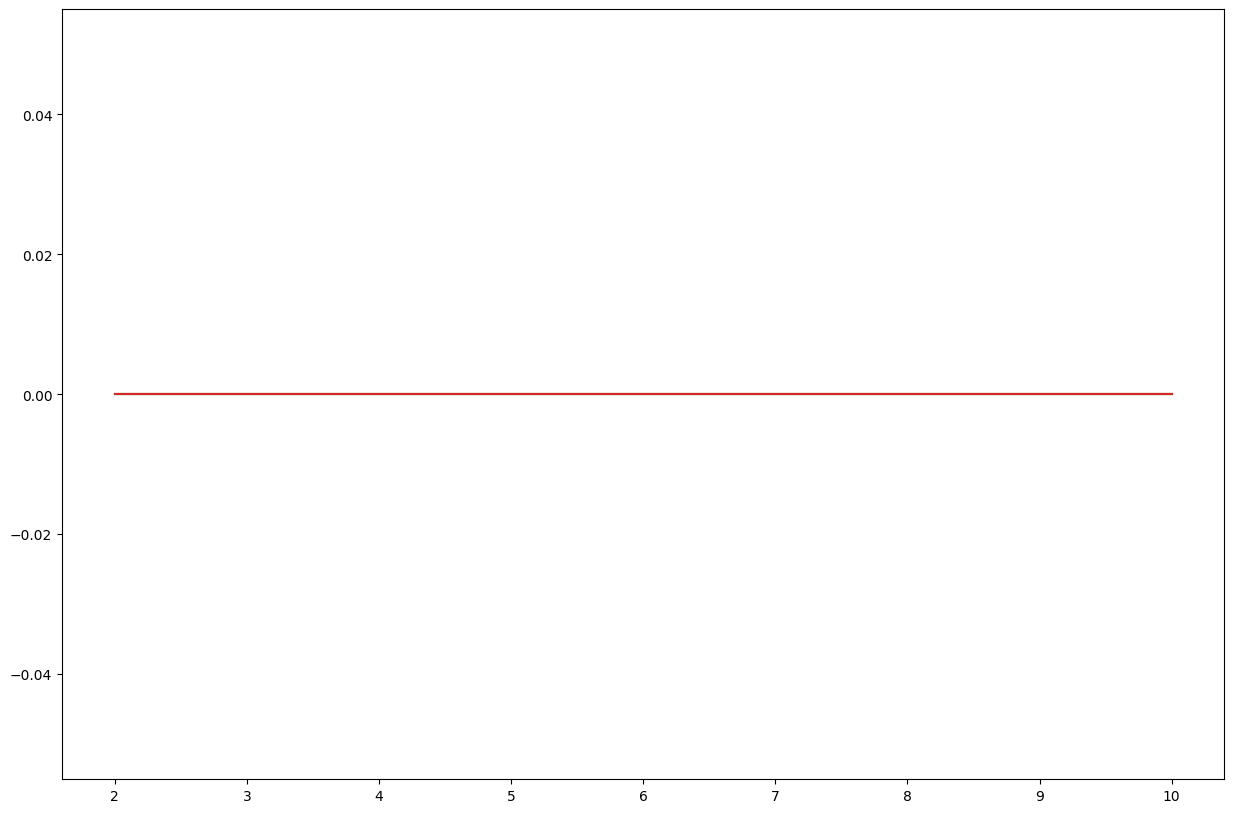

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))
x = [2, 3, 5, 7, 10]
ax.plot(x, SAX_list_k_means_intra_cluster, label="SAX K-means intra-cluster mean distance vs K")
ax.plot(x, SAX_list_k_means_inter_cluster, label="SAX K-means inter-cluster mean distance vs K")
ax.plot(x, TSAX_list_k_means_intra_cluster, label="TSAX K-means intra-cluster mean distance vs K")
ax.plot(x, TSAX_list_k_means_intra_cluster, label="TSAX K-means intra-cluster mean distance vs K")